<a href="https://colab.research.google.com/github/UrielBaldesco/ConvolutionalNeuralNetwork-Projects/blob/main/Conditional_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conditional Generative Adversarial Network
* condition is put in place to get the output

Generative Adversarial Network
* generator network: a neural network that can create or generate new data
* discriminator network: a neural network that can distinguish between real and fake data from the dataset (basically a binary classifier)

* adding a condition to the GAN
  * the condition can be labels, class information, features
  * enables target data generation

Conditioning
* provide y (info) to BOTH generator and discriminator
  * y can be a class label, or any data

Generator Architecture
* input: prior input noise (z) and y
* generator combines both and produces synthetic samples

Discriminator Architecture
* input: real data (x) and info (y)
* discriminator distinguishes between real data and synthetic data generated by the generator conditioned on y

Loss Function
* 2-player minimax game
* log(D(xy)) -> encourages discriminator to classify real samples
* (log(1D(G(zy))) -> encourages generator to produce samples that are classified as real by discriminator
--> allows generator to improve its ability to generate realistic samples, and discriminator to be able to distinguish between real and generates samples conditioned on y
* Binary Cross Entropy Loss: suitable to distinguish between real and fake data in GANs
  * calculates 2 losses:
    * real loss
    * fake loss
* total loss is sum of real and fake loss which represents how well the discriminator is at distinguishing real and fake data


BUILDING THE GENERATOR MODEL
* generator takes a label and noise as input and generates data based on the label
* since there is a condition - then use an embedding layer to change each label into a vector representation

Architecture - Generator
1. input layer provides the label as input to the generators
2. the embedding layer converts the label into a vector representation
3. the input layer provides the noise (latent space input) to the generator
  - the latent space input goes through a series of dense layers + LeakyReLU activation function
4. the label are reshaped and concatenated with the processed latent space
5. the merged data goes through convolution transpose layers

Architecture - Discriminator
1. input layer takes a single value - the label or class info - embedded into a 50 dimensional vector using an embedded layer
2. the label input is embedded into a vector
3. the label is reshaped then concatenated with the input - label info with the image provides conditional info to the discriminator
4. 2 convolutional layers are applied to the concatenated input, leakyrelu activation is after each conv layer to extract the features
5. features maps are flattened, connected to the dense layer - outputs a probability score representing the input data is real or fake

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
latent_size = 100
epochs = 50
learning_rate = 0.001

#add condition: the number of classes
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
train_dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

sample, _ = train_dataset[0]
print(f"shape of input images: {sample.shape}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16537390.67it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 509056.92it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3972328.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11951398.22it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

shape of input images: torch.Size([1, 28, 28])


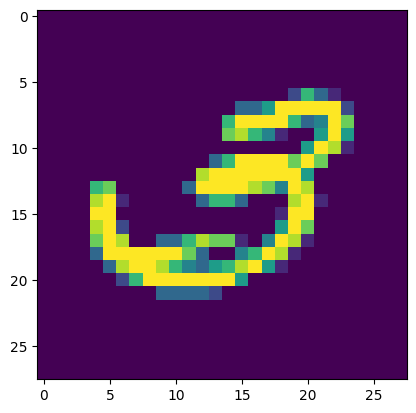

In [3]:
import matplotlib.pyplot as plt
import numpy as np

for images, _ in train_loader:
  image_tensor = images[0]
  break

image_np = image_tensor.squeeze().numpy()
plt.imshow(image_np)
plt.show()

Changes to make GAN conditional:

---


* added new parameters: latent_dim, n_classes
* instantiated these:
  label_embedding
  label_dense
  latent_dense
  latent_leakyrelu

  convolutional layer
  leaky relu

  convolutional layer
  leaky relu

  convolutional layer

* To make the Generator and Discriminator in your GAN conditional, you need to incorporate the class labels into both networks. This involves concatenating the label information with the input noise vector in the Generator and with the input image in the Discriminator
  

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(

        #first layer
        nn.Linear(latent_size + num_classes, 128*7*7),
        nn.LeakyReLU(0.2, inplace=True),

        #reshape the flattened tensor to a 4-D so it can be processed to convolutional layers
        nn.Unflatten(1,(128,7,7)),

        #second layer: upsample
        nn.ConvTranspose2d(128,64,kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        #third layer: upsample
        nn.ConvTranspose2d(64,32,kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),

        #output layer: generate values between [-1,1]
        nn.ConvTranspose2d(32,1,kernel_size=3, stride=1, padding=1),
        nn.Tanh()

    )


  def forward(self, x, labels):
    x = torch.cat([x,labels], dim=1)
    return self.model(x)


In [9]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        #first layer, input size: 11, output size: 32
        nn.Conv2d(1+num_classes, 32, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),

        #second layer: downsample
        nn.Conv2d(32,64,kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        #third layer: downsample
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        #flatten to a 1-D tensor
        nn.Flatten(),
        nn.Linear(128*3*3, 1),
        nn.Sigmoid()
    )

  def forward(self, x, labels):
    labels = labels.view(-1, num_classes, 1,1)
    labels= labels.expand(-1,-1,x.size(2), x.size(3))
    x = torch.cat([x, labels], dim=1)
    return self.model(x)


In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(),lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
d_loss_list = []
g_loss_list = []

for epoch in range(epochs):
  for i, (real_images, labels) in enumerate(train_loader):
    # real_images = real_images.view(-1, 784).to(device)
    real_images = real_images.to(device)
    batch_size = real_images.size(0)
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    #one hot encode the labels
    labels = torch.nn.functional.one_hot(labels, num_classes = num_classes).float().to(device)

    #Train Discriminator
    optimizer_d.zero_grad()
    real_outputs = discriminator(real_images, labels)
    real_loss = criterion(real_outputs, real_labels)

    z = torch.randn(batch_size, latent_size).to(device)
    #one hot encode labels
    fake_labels_gen = torch.nn.functional.one_hot(torch.randint(0,num_classes,(batch_size,)), num_classes=num_classes).float().to(device)
    fake_images = generator(z, fake_labels_gen)
    fake_outputs = discriminator(fake_images.detach(), fake_labels_gen)
    fake_loss = criterion(fake_outputs, fake_labels)

    d_loss = real_loss + fake_loss
    d_loss_list.append(d_loss.item())
    d_loss.backward()
    optimizer_d.step()


    # Train Generator
    optimizer_g.zero_grad()
    #pass into discriminator: fake images and fake labels
    fake_outputs = discriminator(fake_images, fake_labels_gen)
    g_loss = criterion(fake_outputs, real_labels)
    g_loss_list.append(g_loss.item())
    g_loss.backward()
    optimizer_g.step()


    if i % 100 == 0:
      print(f"Epoch [ {epoch}/{epochs}], Step [ {i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

  with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    fixed_labels = torch.nn.functional.one_hot(torch.randint(0,num_classes, (16,)), num_classes=num_classes).float().to(device)
    generated_images = generator(z, fixed_labels).view(-1, 1, 28, 28)
    save_image(generated_images, f"gan_generated_epoch_{epoch+1}.png", nrow=4, normalize=True)




Epoch [ 0/50], Step [ 0/469], D Loss: 0.5813, G Loss: 2.2005
Epoch [ 0/50], Step [ 100/469], D Loss: 0.4513, G Loss: 1.7551
Epoch [ 0/50], Step [ 200/469], D Loss: 0.3745, G Loss: 3.1111
Epoch [ 0/50], Step [ 300/469], D Loss: 0.3098, G Loss: 1.9130
Epoch [ 0/50], Step [ 400/469], D Loss: 0.5115, G Loss: 1.5773
Epoch [ 1/50], Step [ 0/469], D Loss: 0.5947, G Loss: 1.8680
Epoch [ 1/50], Step [ 100/469], D Loss: 0.8282, G Loss: 2.5241
Epoch [ 1/50], Step [ 200/469], D Loss: 0.5766, G Loss: 2.5045
Epoch [ 1/50], Step [ 300/469], D Loss: 0.6679, G Loss: 2.9000
Epoch [ 1/50], Step [ 400/469], D Loss: 0.4707, G Loss: 2.4450
Epoch [ 2/50], Step [ 0/469], D Loss: 0.5880, G Loss: 1.8369
Epoch [ 2/50], Step [ 100/469], D Loss: 0.8277, G Loss: 1.1616
Epoch [ 2/50], Step [ 200/469], D Loss: 0.4776, G Loss: 1.8538
Epoch [ 2/50], Step [ 300/469], D Loss: 0.6826, G Loss: 1.9281
Epoch [ 2/50], Step [ 400/469], D Loss: 0.7416, G Loss: 1.0528
Epoch [ 3/50], Step [ 0/469], D Loss: 0.5350, G Loss: 2.0106


In [16]:
import glob
import cv2

In [17]:
def fn(x):
  return(int(x.split('.')[0].split('_')[-1]))

<ipython-input-18-a3121c310794>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


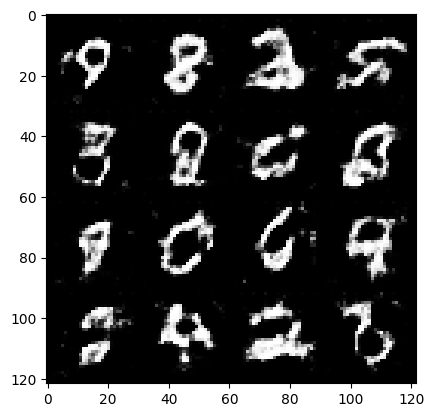

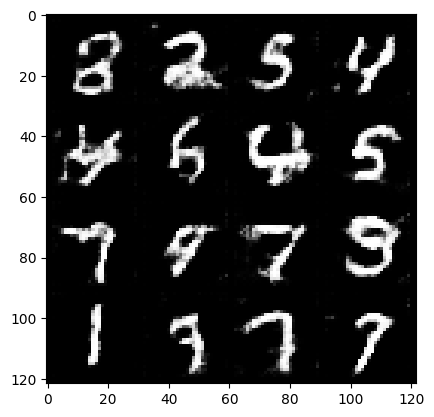

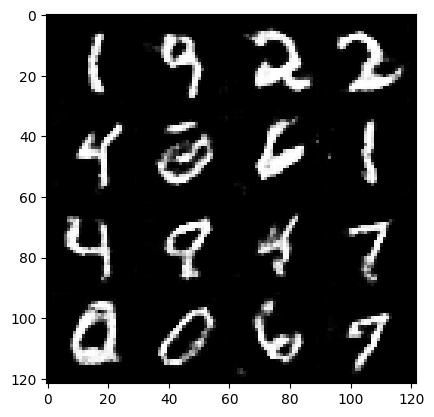

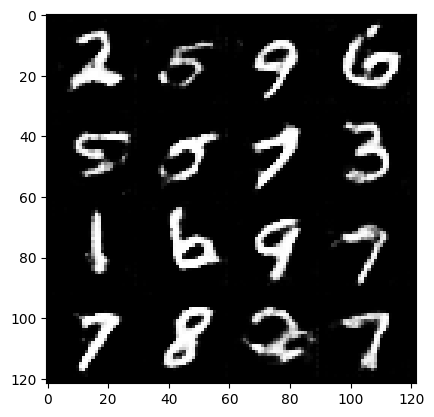

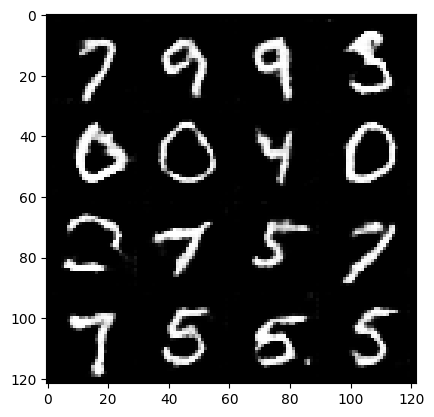

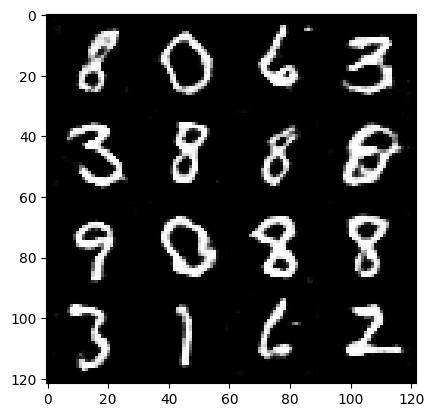

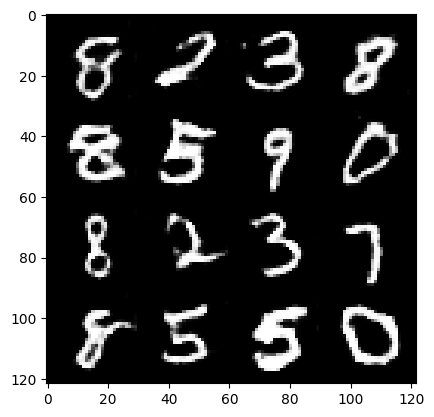

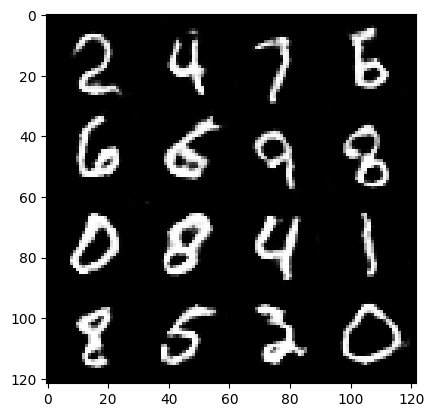

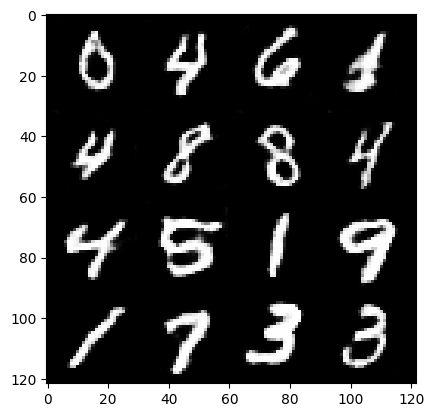

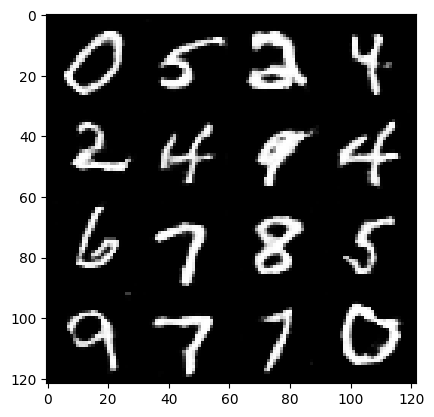

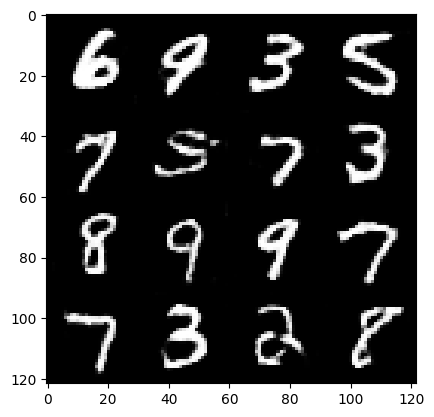

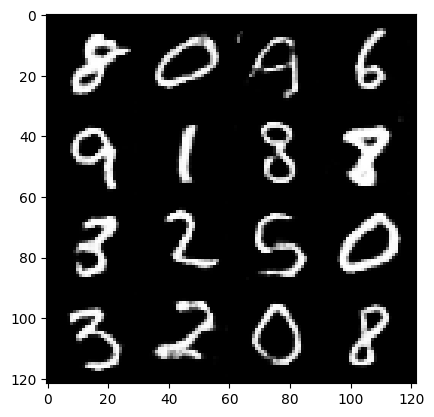

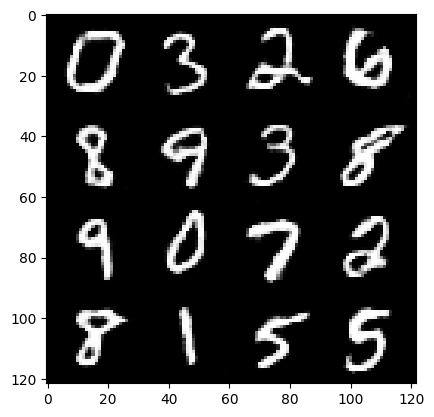

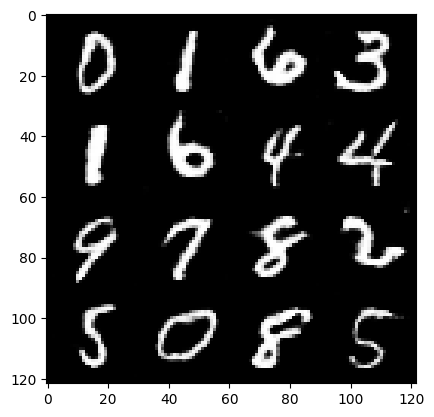

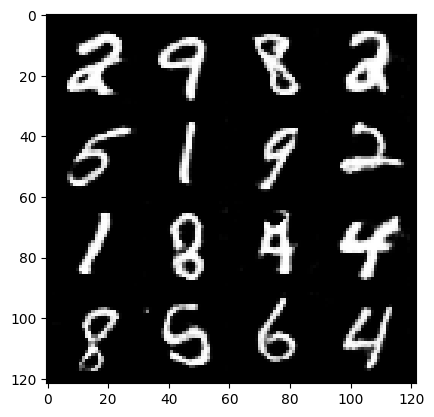

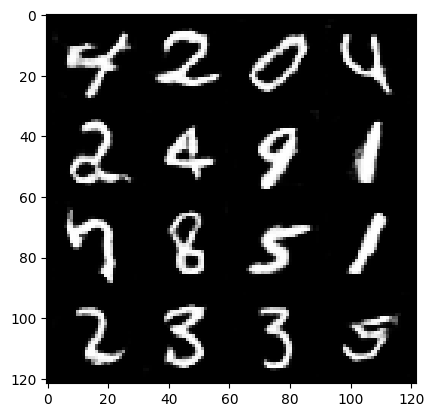

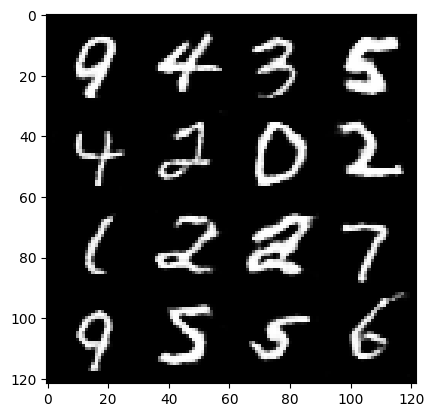

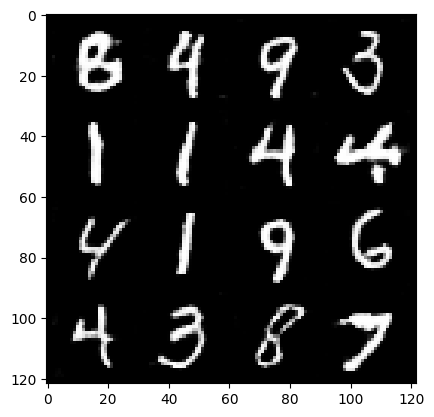

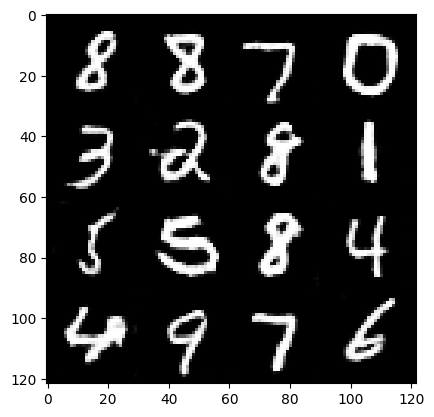

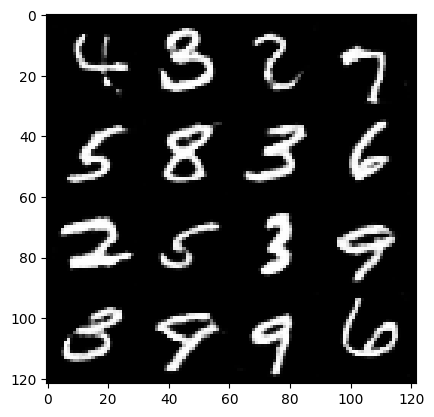

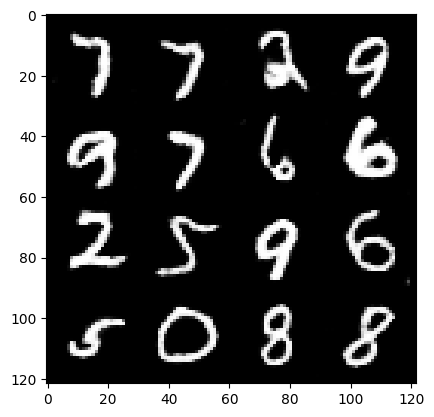

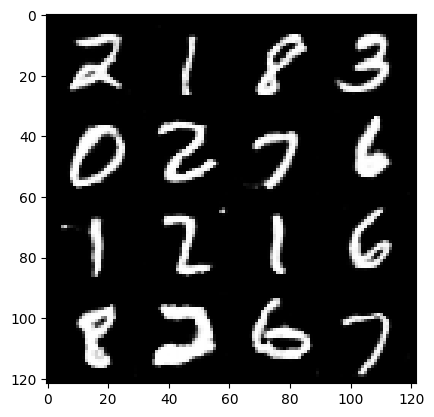

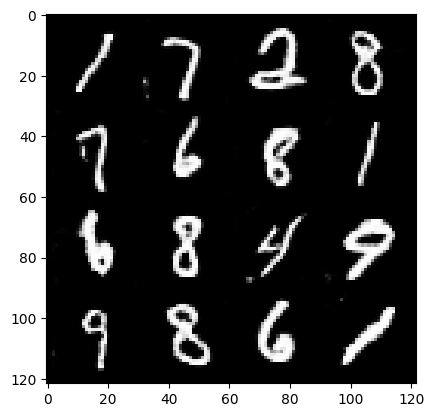

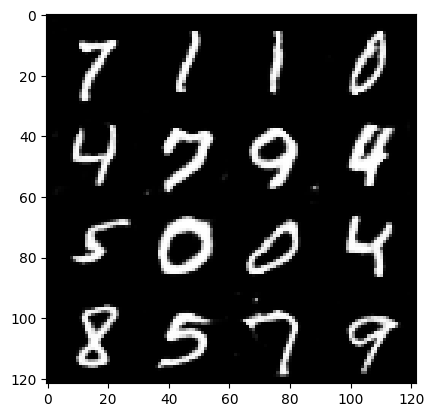

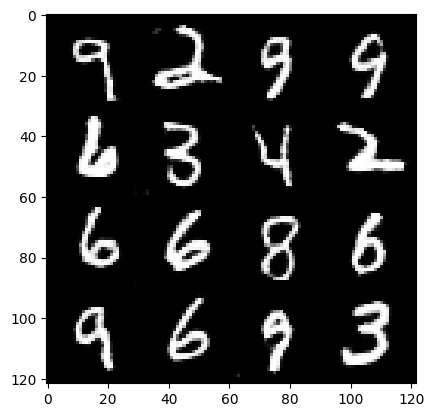

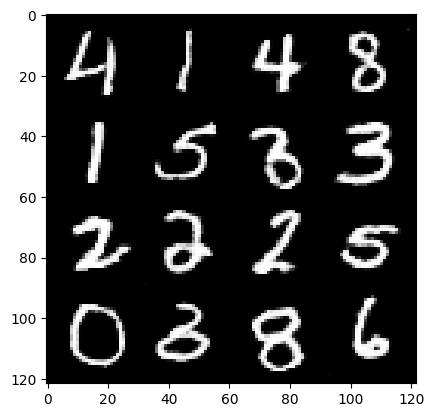

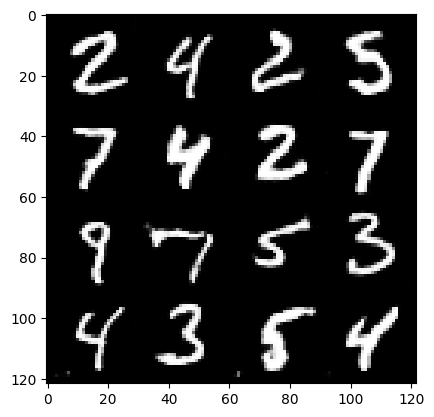

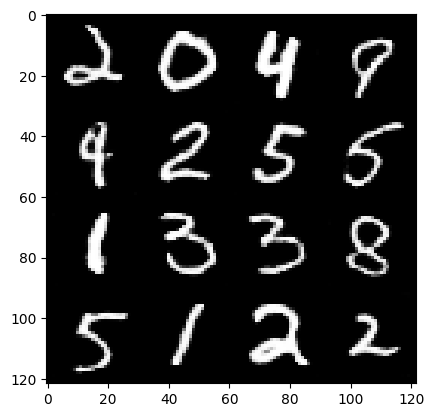

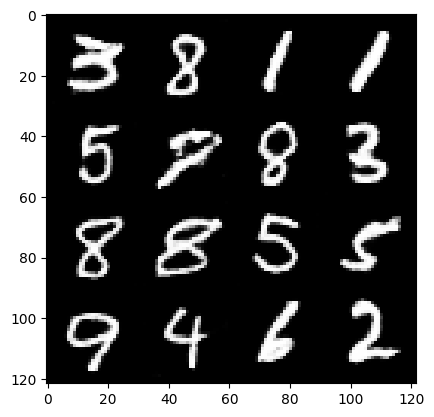

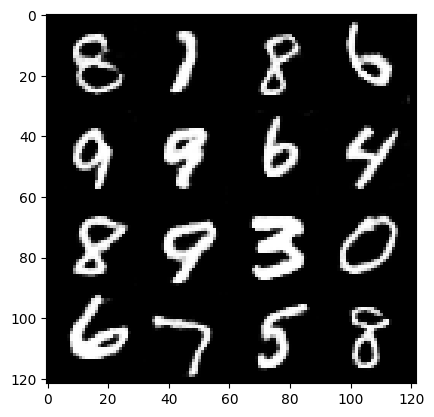

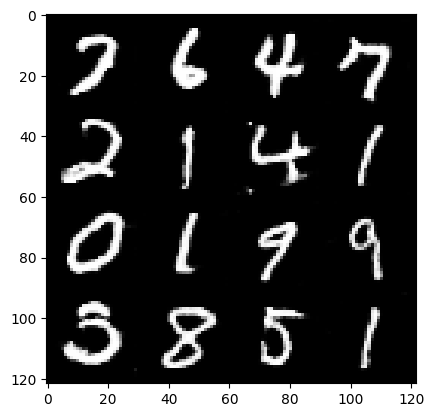

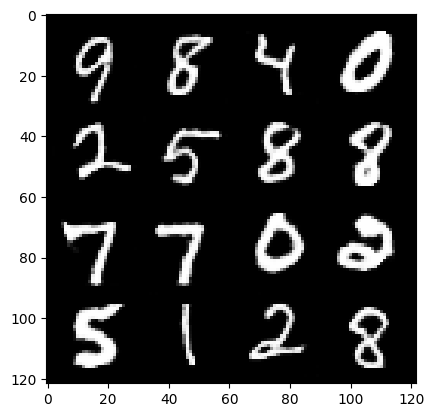

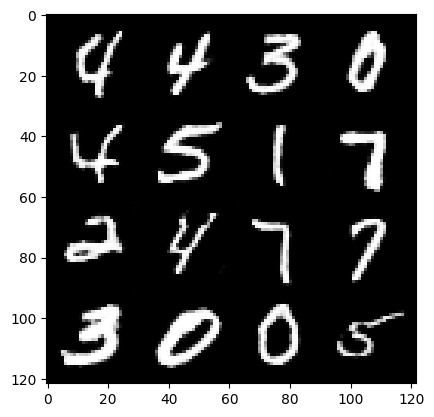

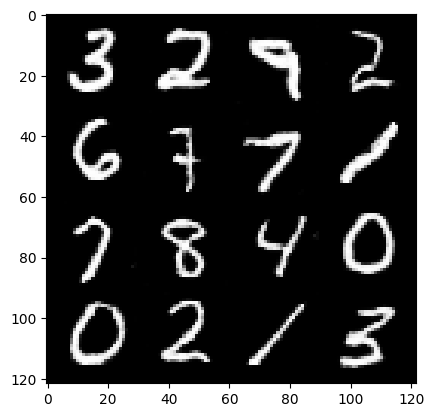

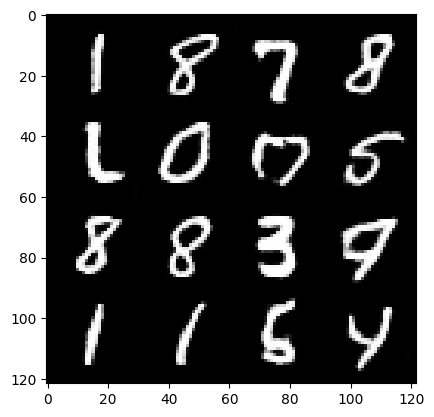

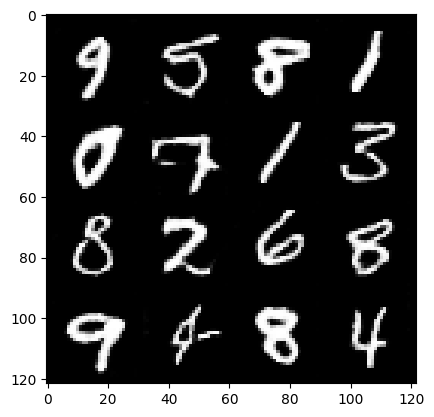

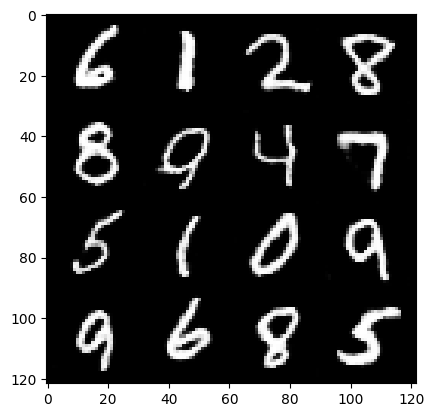

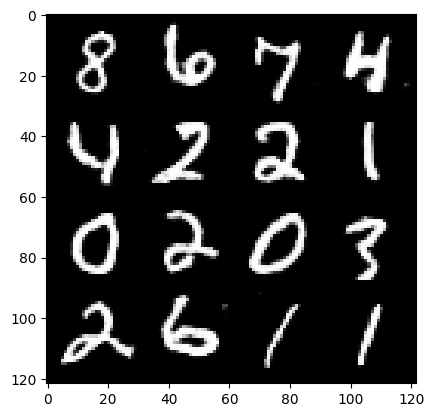

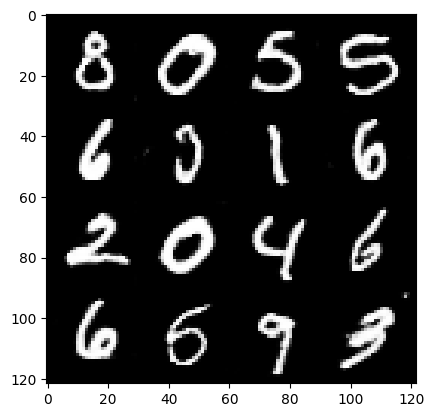

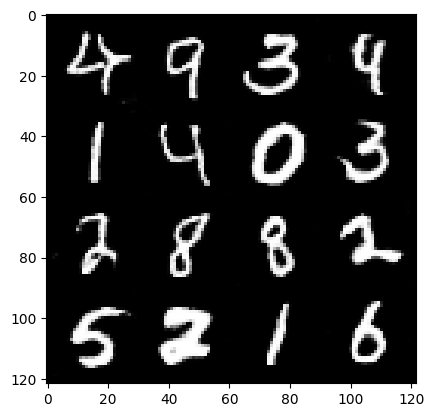

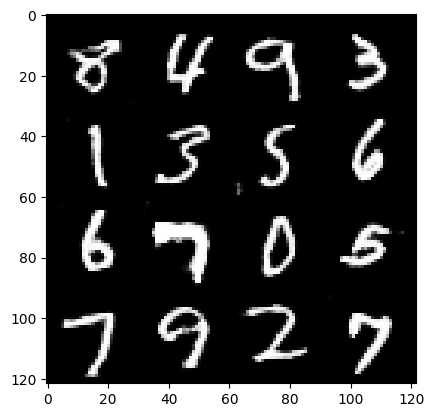

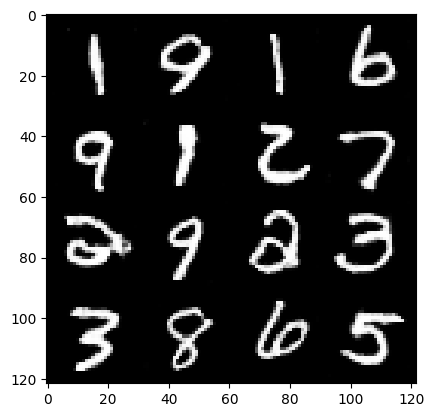

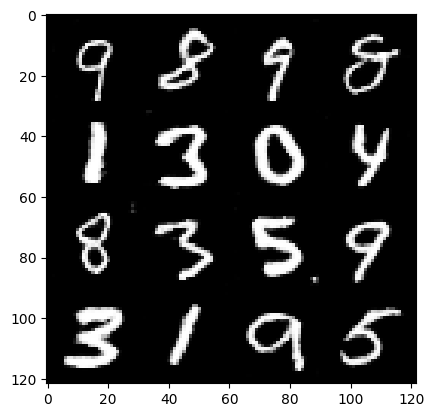

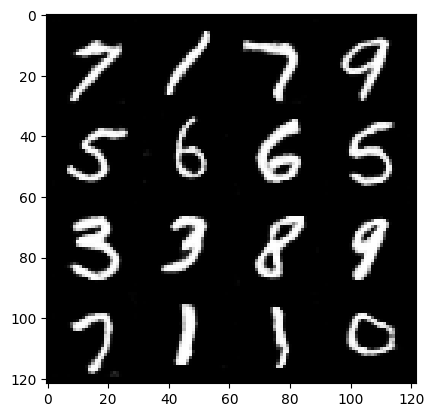

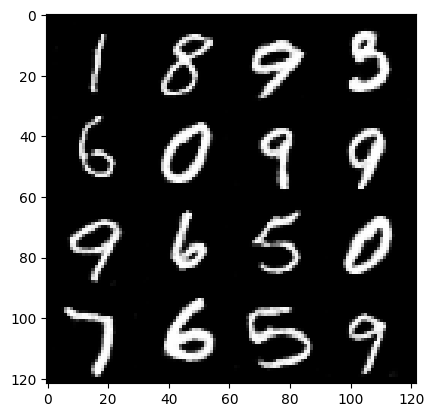

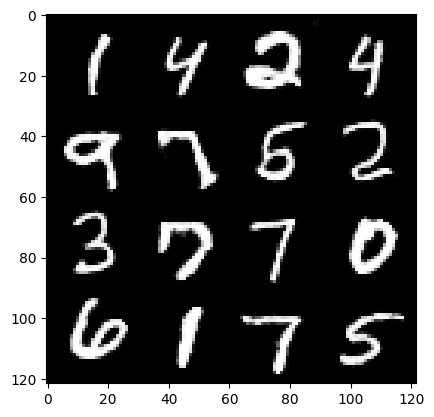

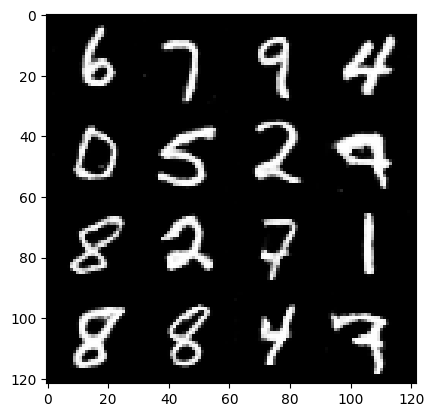

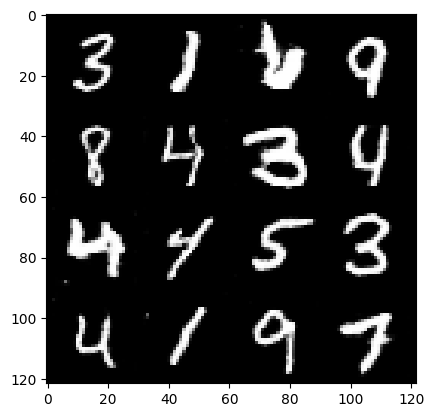

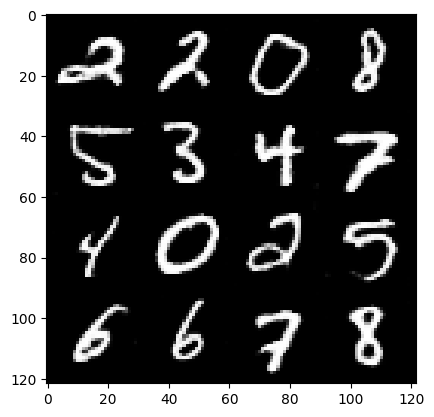

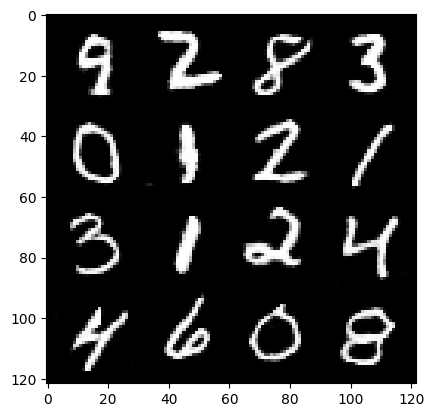

In [18]:
for i in sorted(glob.glob('*.png'),key=fn):
  plt.figure()
  plt.imshow(cv2.imread(i), cmap="gray")

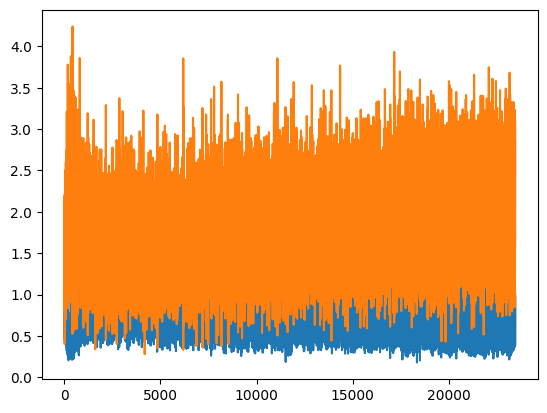

In [19]:
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.show()

torch.float32
torch.float32


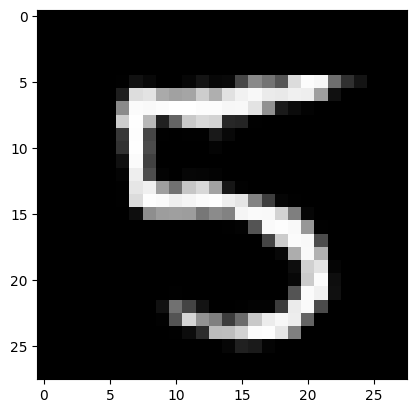

In [20]:
randon_n = torch.tensor(np.random.randn(10, latent_size), dtype=torch.float32).to(device)
print(randon_n.dtype)
one_hotendoder = torch.nn.functional.one_hot(torch.tensor([5]*10), num_classes=num_classes).float().to(device)
print(one_hotendoder.dtype)
img_array = generator(randon_n, one_hotendoder)

img_array.shape
images = img_array.cpu().detach().numpy()
plt.figure()
plt.imshow(images[2][0], cmap="gray")